# NLP: Análisis sentimientos de textos turisticos

Realice un análisis de sentimiento en un conjunto de reseñas de productos. Debe crear un modelo capaz de realizar una clasificación de sentimiento

### Importe de librerias

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Cargue de información

In [18]:
splits = {'train': 'data/train-00000-of-00001-40d9940488cb84b1.parquet', 'test': 'data/test-00000-of-00001-9cc7bacfd2a73ac7.parquet'}
df = pd.read_parquet("hf://datasets/alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad/" + splits["train"])

In [19]:
print(df)

                                                     text  label
0       el mejor lugar para comer sushi. excelente lug...      5
1       vista hermosa!. me sorprendió la maravillosa v...      5
2       desastroso. buenas noches,  ante todo explicar...      1
3       todo bien excepto que se niegan a dar vasos de...      3
4       el mejor zoologico de méxico. el ambiente es m...      5
...                                                   ...    ...
176187  gran hotel con buen servicio. hotel muy bueno,...      5
176188  estancia cómoda en la frontera de puebla y tla...      5
176189  encantador. realmente nos gustó quedarnos en e...      5
176190  en general la atención del personal fue excele...      5
176191  una bellesa en la ciudad. exelente lugar debaj...      5

[176192 rows x 2 columns]


**Comentario:** El Dataset de entrenamiento está conformado por 176.192 opiniones de lugares turisticos los cuales tienen una etiqueta de calificación del sentimiento.

#### División en dataset de entrenamiento y prueba

In [20]:
X = df["text"]
y = df["label"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

# Se convierten a DF para el EDA
df_train = pd.DataFrame({"text": X_train, "label": y_train}).reset_index(drop=True)
df_test = pd.DataFrame({"text": X_test, "label": y_test}).reset_index(drop=True)

### EDA: Análisis exploratorio de datos

In [21]:
# Completitud de los datos
def analisis_datos(df):
    """
    Analiza la completitud de los datos en un DataFrame.
    Muestra la cantidad de valores NaN, espacios en blanco y el porcentaje de valores faltantes por columna.
    """
    columnas = df.columns.tolist()
    espacios_blanco = [df[col].apply(lambda x: isinstance(x, str) and x.isspace()).sum() for col in columnas]
    nan_counts = df.isna().sum().tolist()
    porcentaje_faltantes = [(nan + esp_blanco) / len(df) * 100 for nan, esp_blanco in zip(nan_counts, espacios_blanco)]

    # Crear DataFrame con los resultados
    resultados_df = pd.DataFrame({
        'Columna': columnas,
        'Espacios en Blanco': espacios_blanco,
        'NaN': nan_counts,
        '% Faltantes': porcentaje_faltantes
    })
    
    # Mostrar los resultados
    print("Resultados:")
    print(resultados_df)

In [22]:
def distribucion_sentimientos(df):
    """
    Genera dos gráficos:
    1. Distribución de las calificaciones en un gráfico de barras.
    2. Relación entre la longitud del comentario y la calificación en un boxplot.
    """
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
    
    # Gráfico 1: Distribución de las calificaciones
    df['label'].value_counts().sort_index().plot(kind='bar', colormap='viridis', ax=axes[0])
    axes[0].set_xlabel('Calificación')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de las Calificaciones')
    
    # Calcular la longitud de los comentarios
    df['longitud'] = df['text'].apply(len)
    
    # Gráfico 2: Longitud del texto según calificación
    sns.boxplot(x=df['label'], y=df['longitud'], ax=axes[1])
    axes[1].set_xlabel('Calificación')
    axes[1].set_ylabel('Longitud del comentario')
    axes[1].set_title('Longitud del Texto según Calificación')

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

In [23]:
analisis_datos(df_train)

Resultados:
  Columna  Espacios en Blanco  NaN  % Faltantes
0    text                   0    0          0.0
1   label                   0    0          0.0


In [24]:
analisis_datos(df_test)

Resultados:
  Columna  Espacios en Blanco  NaN  % Faltantes
0    text                   0    0          0.0
1   label                   0    0          0.0


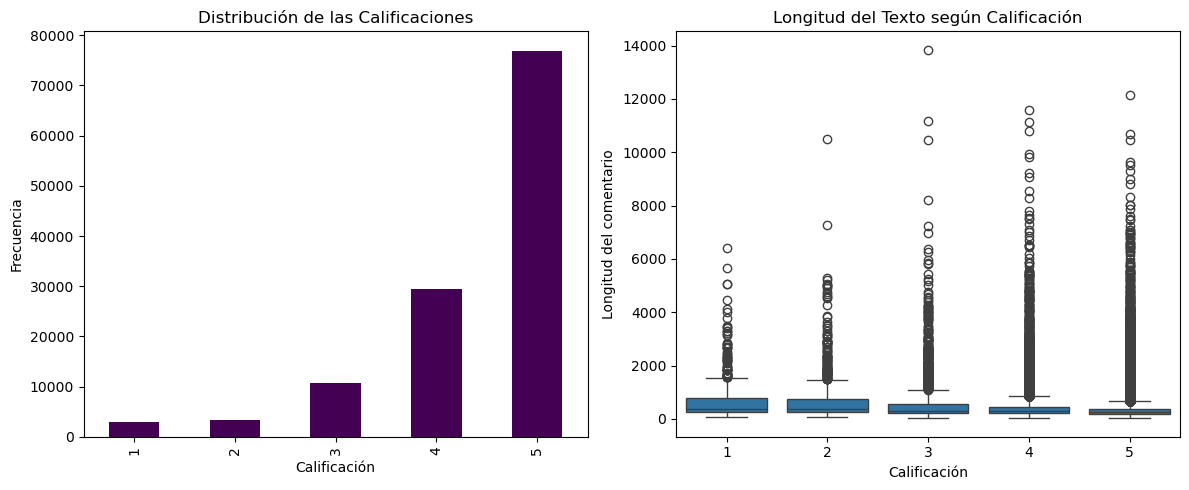

In [25]:
distribucion_sentimientos(df_train)

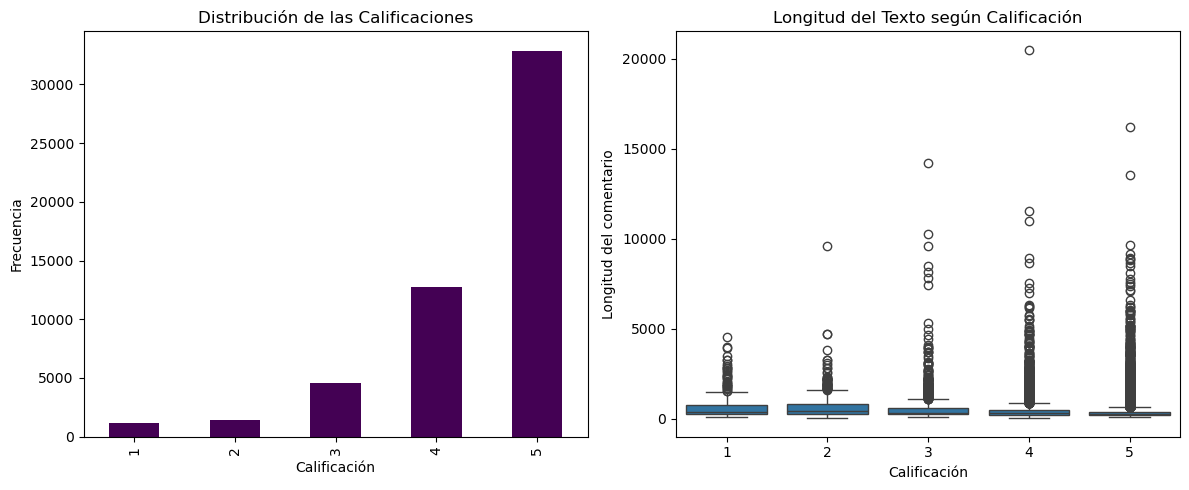

In [26]:
distribucion_sentimientos(df_test)

**Comentarios**:
- Se evaluó la completitud de los datos y se osbervó que no hay espacios en blanco o valores faltantes, por lo que no se debe realizar un preprocesamiento en relación con la completitud.

### Preprocesamiento

Se aplican a continuación técnicas de procesamiento de lenguaje natural (NPL) para extraer información relevante, identificar patrones y facilitar el análisis de los datos.

In [68]:
import unicodedata

# Descargar stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("spanish"))
stopwords_personalizadas = {"habitacion", "hotel", "restaurante", "servicio", "comida", "lugar", "dia", "noche", "edificio", "piscina", "precio", "ademas", "ma", "habia", "habitaciones", "solo", "si", "no"} 

def preprocesamiento_texto(texto):
    """Preprocesa un texto aplicando limpieza, eliminación de stopwords y 
    lematización"""

    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar tildes
    texto = "".join(
        c for c in unicodedata.normalize("NFD", texto) if unicodedata.category(c) != "Mn"
    )

    # Eliminar caracteres especiales y signos de puntuación
    texto = re.sub(r"[^\w\s]", "", texto, flags=re.UNICODE)
    
    # Eliminar stopwords
    palabras = texto.split()
    palabras = [word for word in palabras if word not in stop_words and word not in stopwords_personalizadas]

    # Lematización
    lematizador = WordNetLemmatizer()
    palabras = [lematizador.lemmatize(word) for word in palabras]

    # Unir palabras procesadas
    texto_preprocesado = " ".join(palabras)

    return texto_preprocesado

def preprocesar_y_vectorizar(X_train, X_test, vectorizer):
    """Preprocesa los textos y aplica vectorización en X_train y X_test."""
    
    # Aplicar preprocesamiento de texto
    X_train_proc = X_train.astype(str).apply(preprocesamiento_texto)
    X_test_proc = X_test.astype(str).apply(preprocesamiento_texto)

    # Ajustar y transformar con el vectorizador
    X_train_vec = vectorizer.fit_transform(X_train_proc)
    X_test_vec = vectorizer.transform(X_test_proc)

    return X_train_proc, X_test_proc, X_train_vec, X_test_vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
#vectorizer=CountVectorizer()
vectorizer = TfidfVectorizer(max_features=5000)
X_train_proc, X_test_proc, X_train_vec, X_test_vec = preprocesar_y_vectorizar(X_train, X_test, vectorizer)

### Modelo de predicción: Clasificación

In [74]:
# Inicializar y entrenar el modelo
modelo = MultinomialNB()
modelo.fit(X_train_vec, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_test_vec)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

print("\n🔹 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\n🔹 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

🔹 Accuracy: 0.6667

🔹 Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.66      0.37      0.47      1191
           2       0.44      0.06      0.11      1458
           3       0.42      0.21      0.28      4594
           4       0.44      0.18      0.25     12744
           5       0.71      0.96      0.81     32871

    accuracy                           0.67     52858
   macro avg       0.53      0.35      0.38     52858
weighted avg       0.61      0.67      0.60     52858


🔹 Matriz de Confusión:
[[  435    62   344    66   284]
 [  143    87   573   234   421]
 [   64    34   978  1248  2270]
 [   11    11   356  2239 10127]
 [    9     3    74  1282 31503]]


In [71]:
from wordcloud import WordCloud

def generar_nubes_palabras(df):
    """Genera nubes de palabras para cada calificación en el dataset de entrenamiento."""
    
    for rating in sorted(df['label'].unique()):  # Ordenar categorías
        text = " ".join(df[df['label'] == rating]['text'].dropna().astype(str))  # Convertir a string y eliminar NaN
        
        if text.strip():  # Evita nubes vacías
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white', 
                colormap='viridis'
            ).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f'Nube de Palabras para Calificación {rating}')
            plt.show()

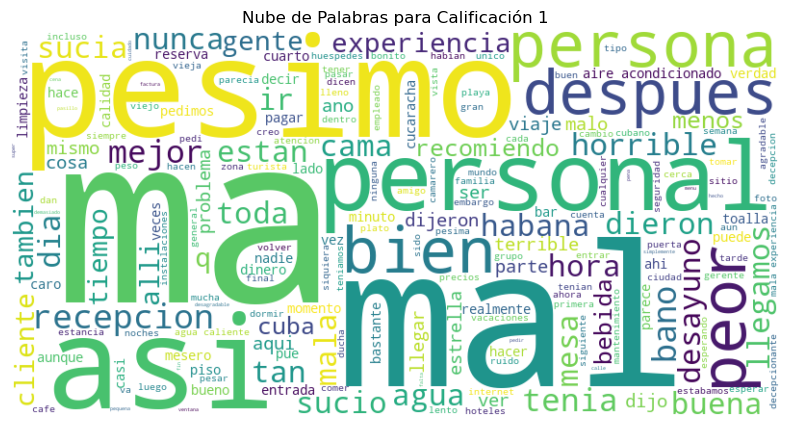

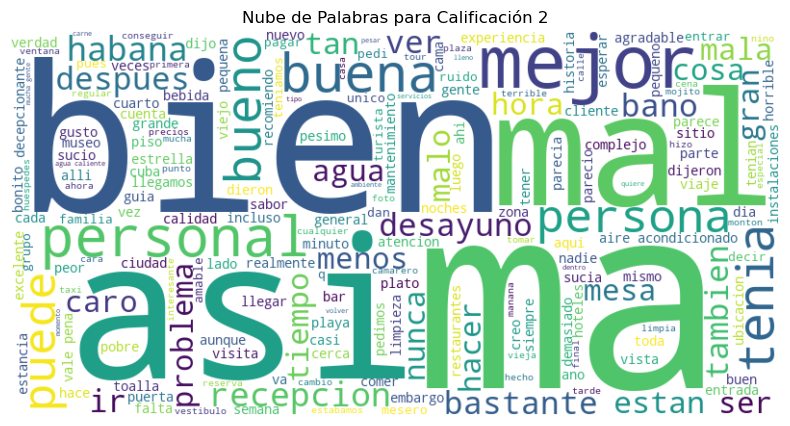

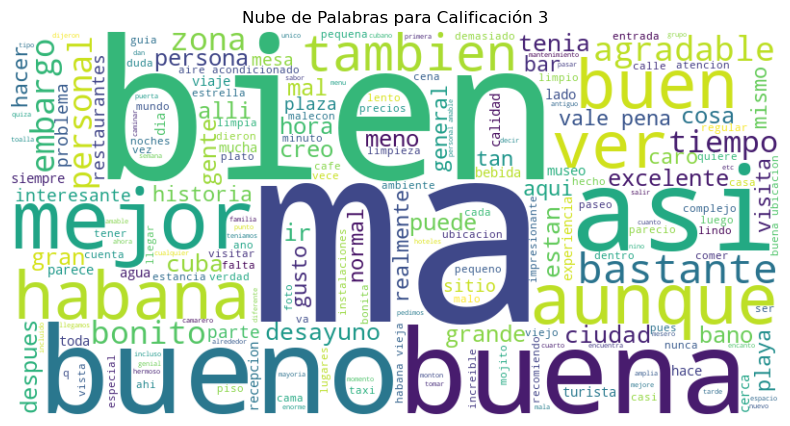

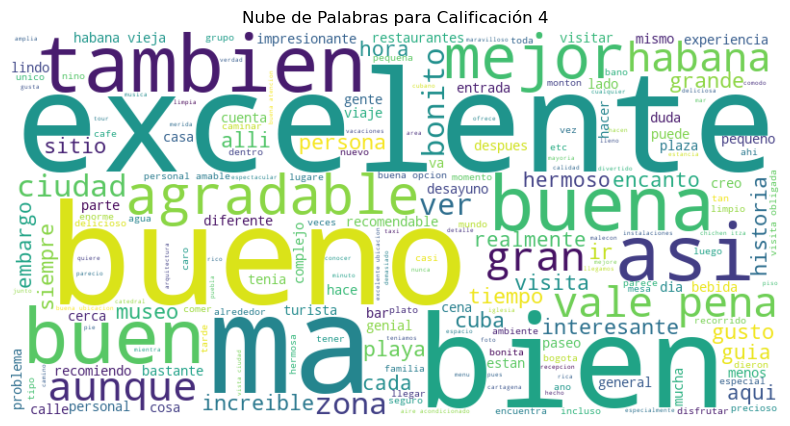

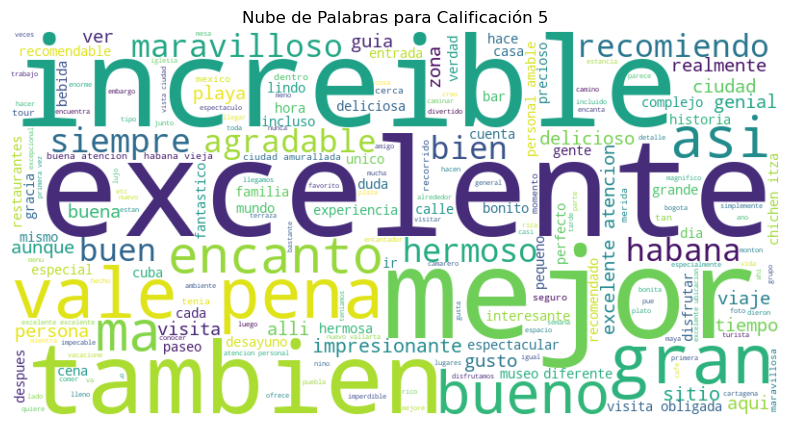

In [72]:
df_train_proc = pd.DataFrame({"text": X_train_proc, "label": y_train}).reset_index(drop=True)

generar_nubes_palabras(df_train_proc)